<img src="images/tennisballbounce1.jpg" alt="Drawing" style="width: 200px;"/><img src="images/rafashot.jpg" alt="Drawing" style="width: 192px;"/>

## ATP Match Study: Inference Analysis

In this notebook, we're looking at the statistical significance of distribution differences between match statistics of winners versus losers (non-winners). This is not testing all of the match statistics; only those that seemed relevant for the model built in the EDA notebook.

In [1]:
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [2]:
# Import Match Statistics csv file.
result = pd.read_csv('data/result.csv')

In [4]:
wins = result.loc[result.win == True,:].copy()
loses = result.loc[result.win == False,:].copy()

In [5]:
# Seed Random
np.random.seed(500)

# Set default for figure sizes
mlp.rcParams['figure.figsize'] = (16,6)

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Define Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,10000)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


    ## CI_area = perm_replicates[perm_replicates <= CI[0]]
    ## _ = plt.hist(CI_area)

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

### Comment here.

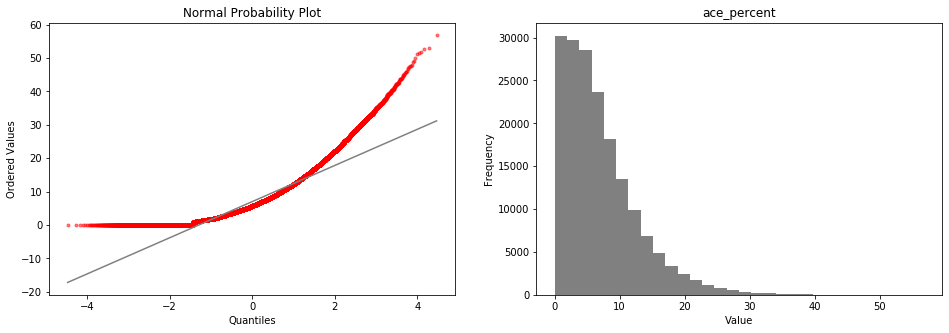

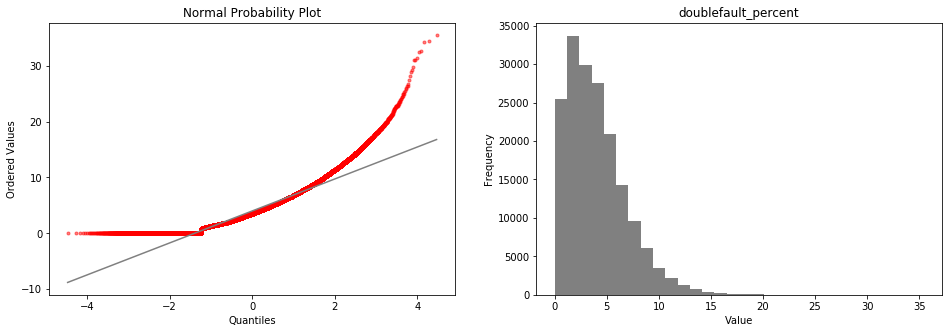

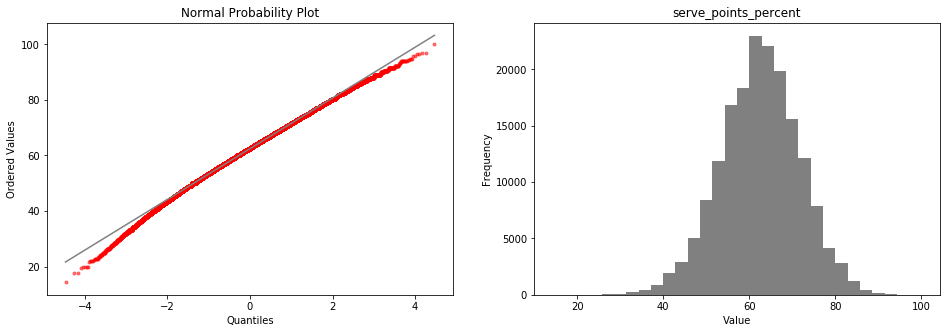

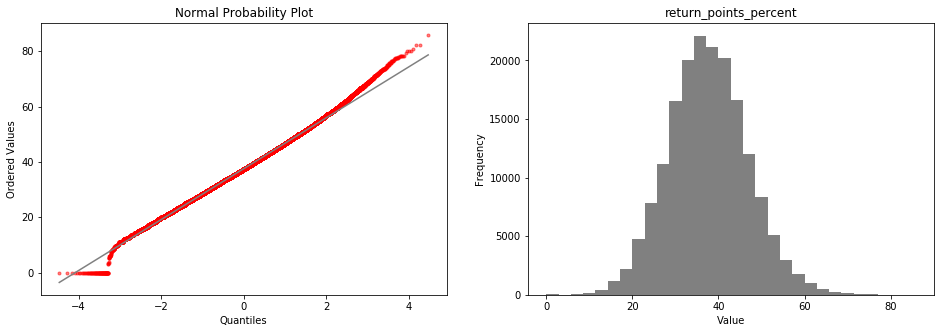

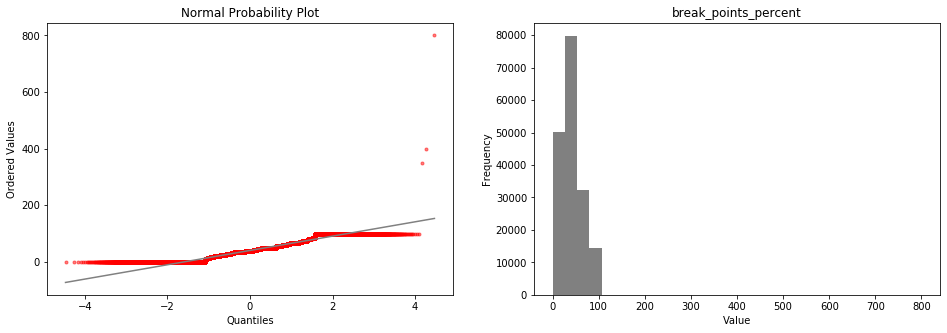

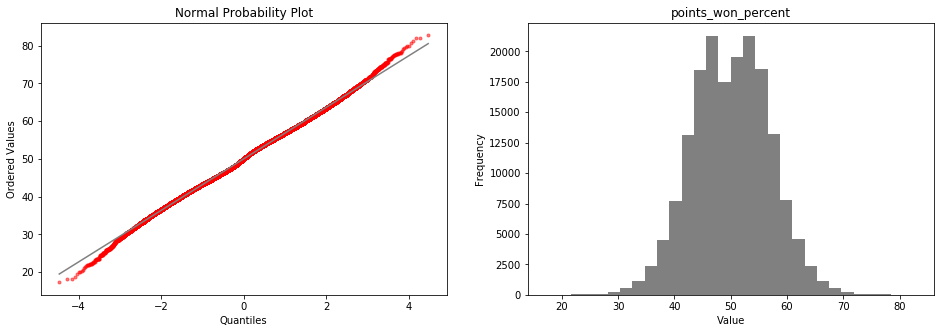

In [7]:
def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq_plot(data):
    data_no_na = data.dropna()
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    _ = plt.subplot(1,2,1)
    (x,y), (slope,intercept,r) = stats.probplot(data_no_na, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    _ = plt.plot(x_lreg,y_lreg,color='gray')
    _ = plt.xlabel('Quantiles')
    _ = plt.ylabel('Ordered Values')
    _ = plt.title('Normal Probability Plot')
    _ = plt.subplot(1,2,2)
    _ = plt.hist(data_no_na, color='gray',bins=30)
    _ = plt.xlabel('Value')
    _ = plt.ylabel('Frequency')

features = ['ace_percent','doublefault_percent','serve_points_percent','return_points_percent',
            'break_points_percent','points_won_percent']
no_discrete_ft = ['ace_percent','doublefault_percent','serve_points_percent','return_points_percent',
            'break_points_percent','points_won_percent']

for feature in no_discrete_ft:
    qq_plot(result[feature])
    plt.title(feature)

## Ace Percent Distribution

Wins Mean: 8.341499386657665
Loses Mean: 5.599406595482732
Mean Diff: 2.742092791174933
H0 Diff: 0


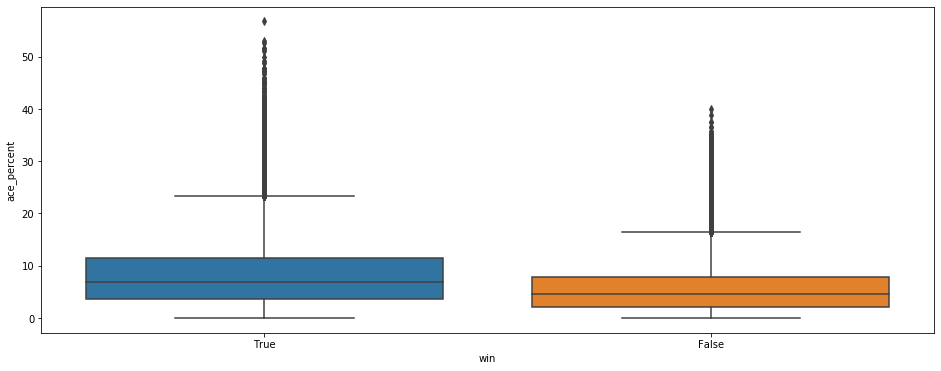

p: 0.0
CI: [-0.05244194  0.05382206]
ME: 0.05376884382623585


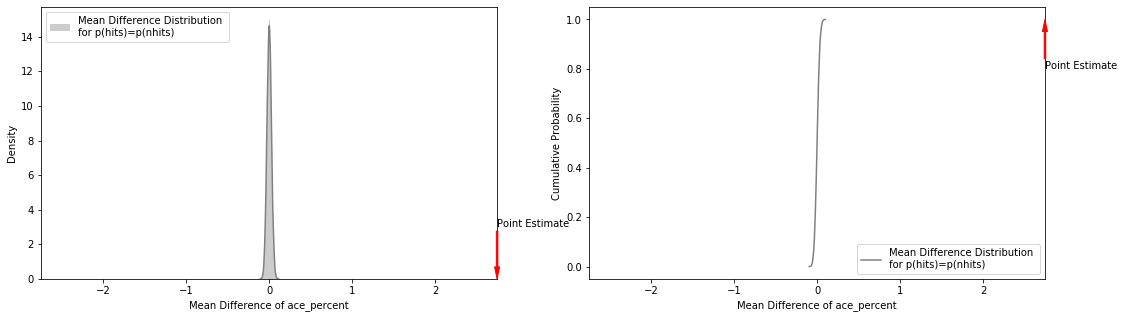

In [12]:
wins_ace_percent = wins.ace_percent.dropna()
loses_ace_percent = loses.ace_percent.dropna()

wins_loses_diff = wins_ace_percent.mean() - loses_ace_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.ace_percent.mean(),
        loses.ace_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='ace_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_ace_percent,loses_ace_percent,wins_loses_diff)

## Double Faults Percent Distribution

Wins Mean: 3.471344897423001
Loses Mean: 4.51147390392976
Mean Diff: -1.040129006506759
H0 Diff: 0


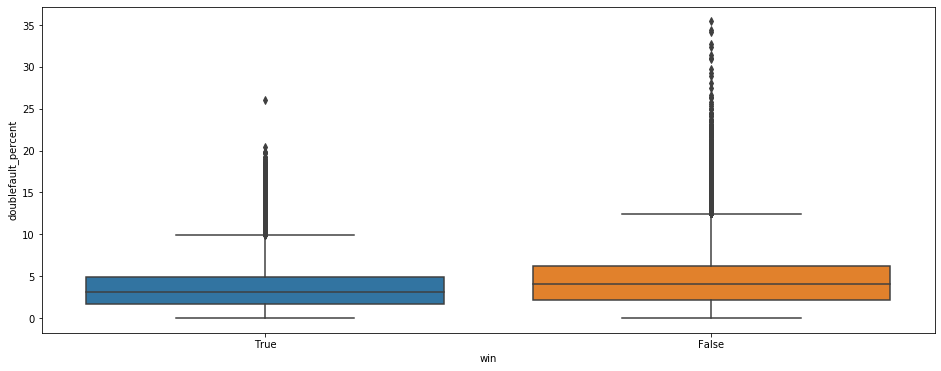

p: 0.0
CI: [-0.02812791  0.02781613]
ME: 0.027850884185069102


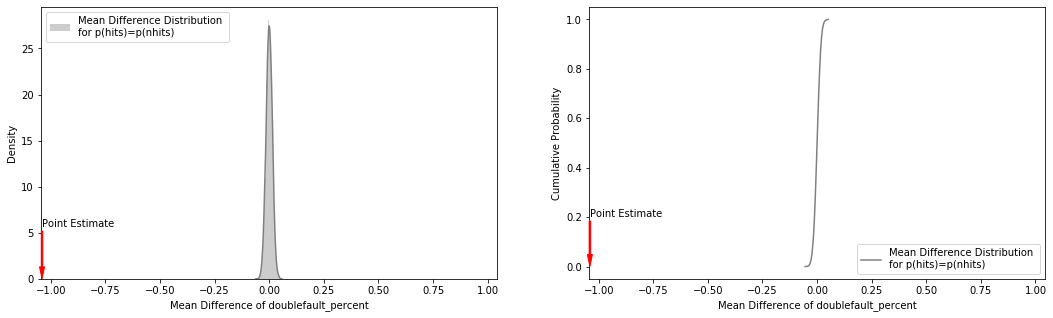

In [14]:
wins_doublefault_percent = wins.doublefault_percent.dropna()
loses_doublefault_percent = loses.doublefault_percent.dropna()

wins_loses_diff = wins_doublefault_percent.mean() - loses_doublefault_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.doublefault_percent.mean(),
        loses.doublefault_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='doublefault_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_doublefault_percent,loses_doublefault_percent,wins_loses_diff)

## Serve Points Percent Distribution serve_points_percent

Wins Mean: 68.22409134342388
Loses Mean: 56.69453624886679
Mean Diff: 11.52955509455709
H0 Diff: 0


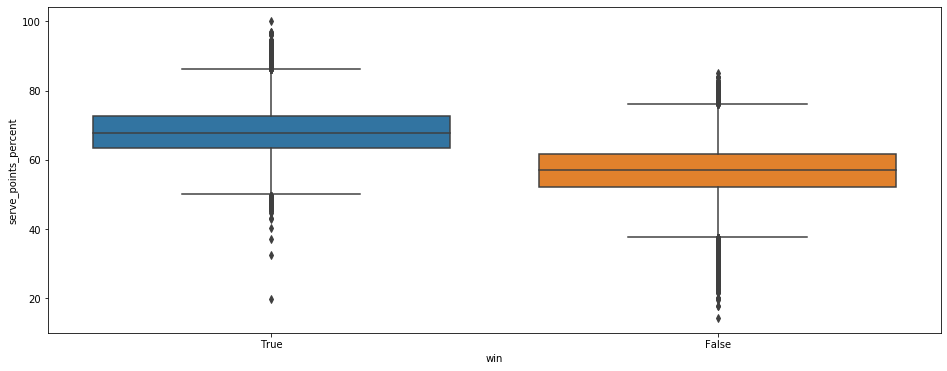

p: 0.0
CI: [-0.08576138  0.08497495]
ME: 0.08522752103632583


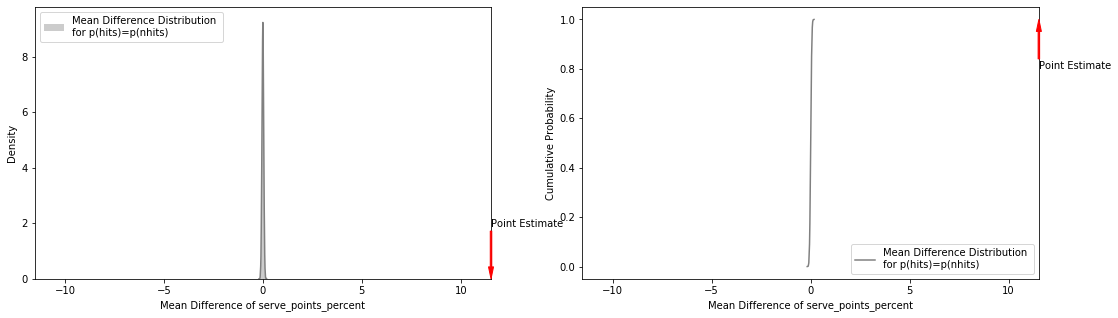

In [15]:
wins_serve_points_percent = wins.serve_points_percent.dropna()
loses_serve_points_percent = loses.serve_points_percent.dropna()

wins_loses_diff = wins_serve_points_percent.mean() - loses_serve_points_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.serve_points_percent.mean(),
        loses.serve_points_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='serve_points_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_serve_points_percent,loses_serve_points_percent,wins_loses_diff)

## Return Points Percent Distribution return_points_percent

Wins Mean: 43.31932649685244
Loses Mean: 31.800988142437046
Mean Diff: 11.518338354415395
H0 Diff: 0


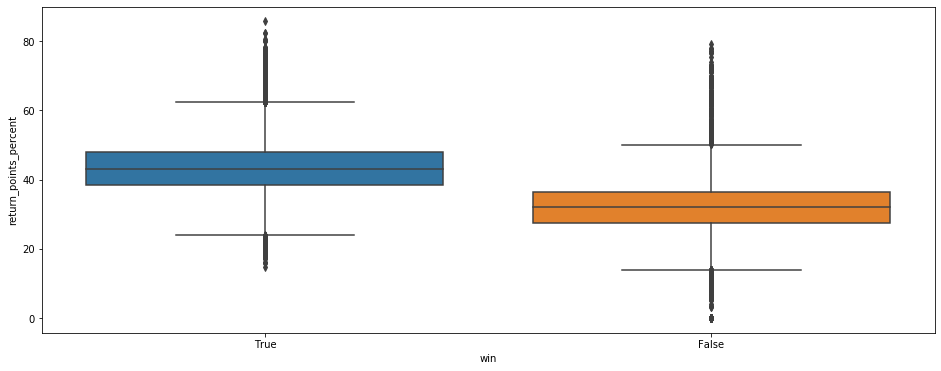

p: 0.0
CI: [-0.08762162  0.08471102]
ME: 0.08544391646176461


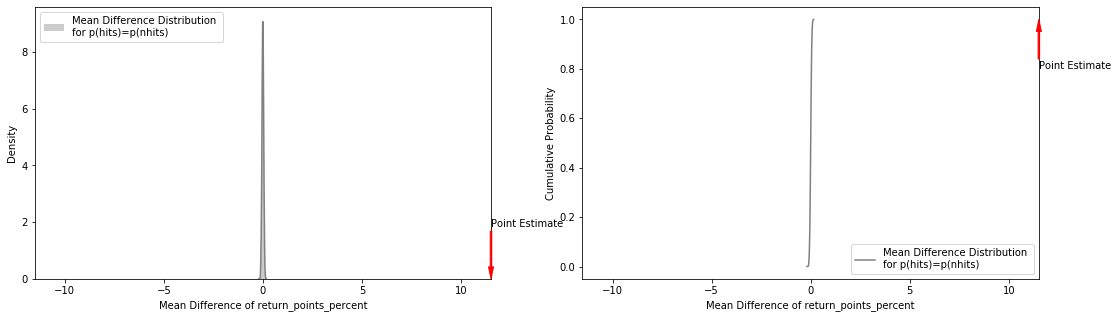

In [16]:
wins_return_points_percent = wins.return_points_percent.dropna()
loses_return_points_percent = loses.return_points_percent.dropna()

wins_loses_diff = wins_return_points_percent.mean() - loses_return_points_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.return_points_percent.mean(),
        loses.return_points_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='return_points_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_return_points_percent,loses_return_points_percent,wins_loses_diff)

## Break Points Percent Distribution break_points_percent

Wins Mean: 49.53973081949633
Loses Mean: 31.589917856741184
Mean Diff: 17.949812962755143
H0 Diff: 0


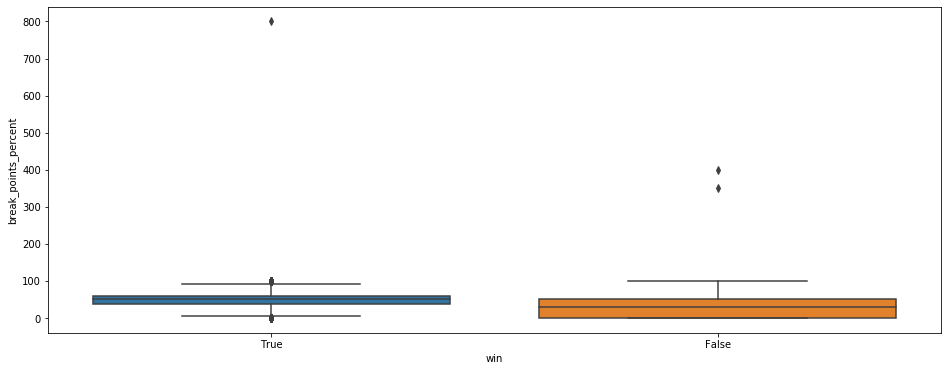

p: 0.0
CI: [-0.24060966  0.23716114]
ME: 0.23701597983864808


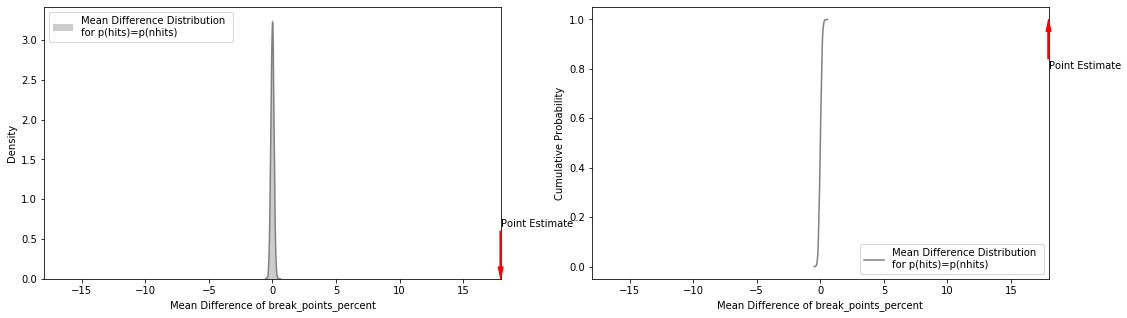

In [17]:
wins_break_points_percent = wins.break_points_percent.dropna()
loses_break_points_percent = loses.break_points_percent.dropna()

wins_loses_diff = wins_break_points_percent.mean() - loses_break_points_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.break_points_percent.mean(),
        loses.break_points_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='break_points_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_break_points_percent,loses_break_points_percent,wins_loses_diff)

## Points Won Percent Distribution points_won_percent

Wins Mean: 55.46809075246928
Loses Mean: 44.56711314840032
Mean Diff: 10.900977604068963
H0 Diff: 0


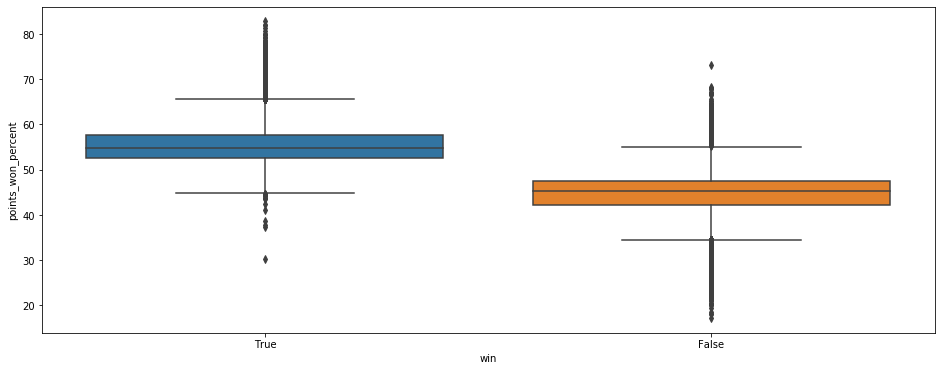

p: 0.0
CI: [-0.06326041  0.06242931]
ME: 0.0626196129030174


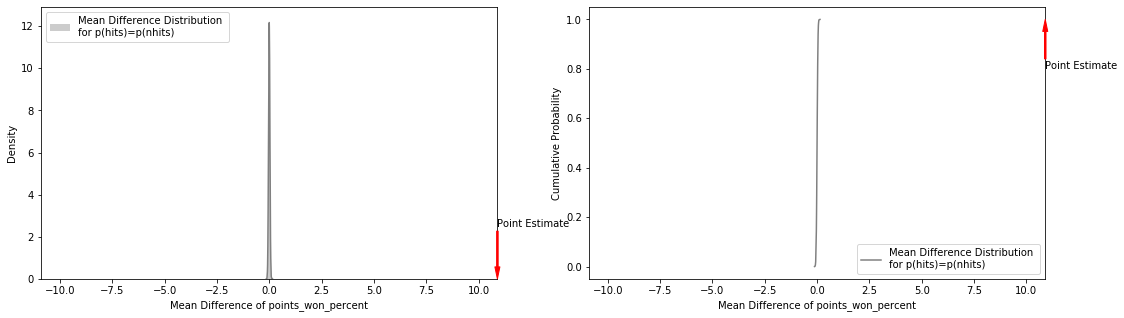

In [19]:
wins_points_won_percent = wins.points_won_percent.dropna()
loses_points_won_percent = loses.points_won_percent.dropna()

wins_loses_diff = wins_points_won_percent.mean() - loses_points_won_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.points_won_percent.mean(),
        loses.points_won_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='points_won_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_points_won_percent,loses_points_won_percent,wins_loses_diff)

## Just checking something...

Wins Mean: 49.53973081949633
Loses Mean: 49.53973081949633
Mean Diff: 0.0
H0 Diff: 0


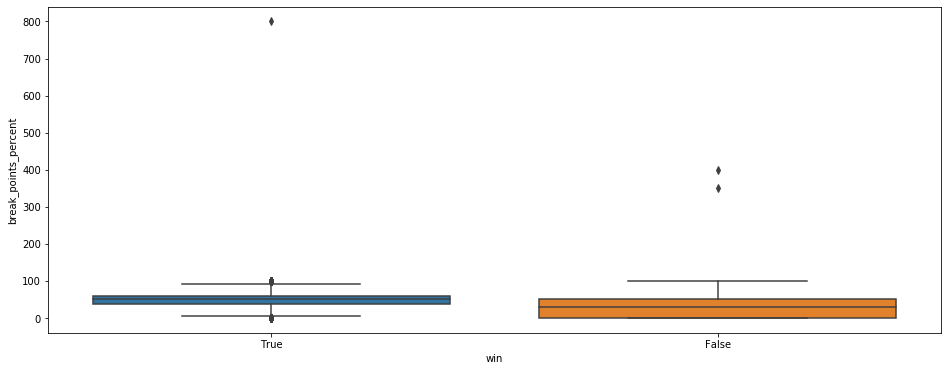

p: 0.5002
CI: [-0.18216806  0.18275269]
ME: 0.18196667067939853


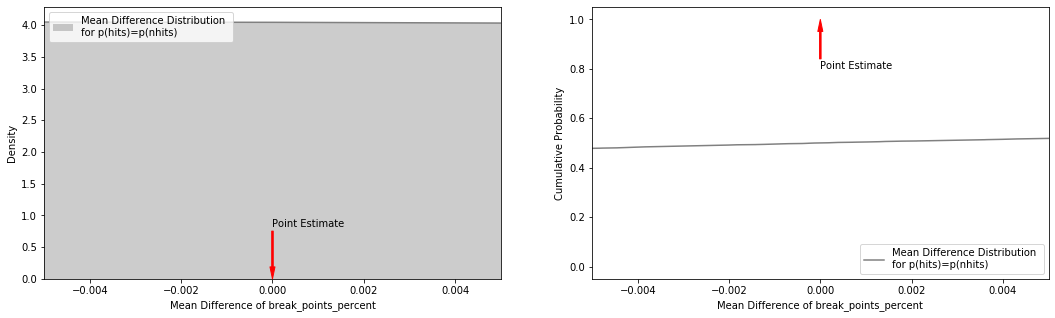

In [21]:
wins_break_points_percent = wins.break_points_percent.dropna()
loses_break_points_percent = wins.break_points_percent.dropna()

wins_loses_diff = wins_break_points_percent.mean() - loses_break_points_percent.mean()
h0_diff = 0
print("Wins Mean: {}\nLoses Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(wins.break_points_percent.mean(),
        wins.break_points_percent.mean(), wins_loses_diff,h0_diff))

sns.boxplot(x='win',y='break_points_percent',data=result,order=[True,False])
plt.show()

test_mean_diff(wins_break_points_percent,loses_break_points_percent,wins_loses_diff)